# Content of this notebook:
- implement a VGG network from scratch to undertand how the image transform during forward pass

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import pickle

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Dataset Cifar100

 - training data set: 40000, validation 10000, test 10000
 - classes 100:
     - 600 images per class * 100 classes = 60.000
     - classes divided into 20 superclasses with 5 subclasses
     - each image has a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)
     - Example: people -> baby, boy, girl, man, woman; people -> superclass, baby, boy, .... -> subclasses 
     - The network has to predict the right subclass label  
     - source: https://www.cs.toronto.edu/~kriz/cifar.html


- Data Augmentation:
    - transforms.ToTensor(): converts the input data into a tensor, takes inputs as a PIL image or a NumPy array and converts it into a tensor. This allows the data       to be directly processed by PyTorch models.    
    - transforms.Normalize(): transformation normalizes the tensor by subtracting the mean and dividing by the standard deviation. The mean is set to (0.5, 0.5, 0.5)       and the standard deviation is set to (0.5, 0.5, 0.5). Normalization helps bring the data into a similar range of values and improves the model's ability.
    - transforms.Compose(): takes a list of transformations and applies them sequentially to the data
    - source: https://pytorch.org/vision/stable/transforms.html

### 1.1 Data augmentation and splitting the data set

In [2]:
batch_size = 64

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training data
with open('cifar-100-python/train', 'rb') as f:
    data_dict = pickle.load(f, encoding='bytes')
train_images = np.array(data_dict[b'data']).reshape((-1, 3, 32, 32)).astype(np.float32)
train_labels = np.array(data_dict[b'fine_labels']).astype(np.int64)

# Load test data
with open('cifar-100-python/test', 'rb') as f:
    data_dict = pickle.load(f, encoding='bytes')
test_images = np.array(data_dict[b'data']).reshape((-1, 3, 32, 32)).astype(np.float32)
test_labels = np.array(data_dict[b'fine_labels']).astype(np.int64)

# Split training data into training and validation sets
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size
train_images, val_images = np.split(train_images, [train_size])
train_labels, val_labels = np.split(train_labels, [train_size])


# Convert data to PyTorch tensors and apply transformations
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_images), torch.from_numpy(val_labels))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels))

train_dataset.transform = transform
test_dataset.transform = transform
val_dataset.transform = transform

# Create data loader 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Len of Train-, Val- and Testdataset
print('Number of training images train data set: ', len(train_dataset))
print('Number of validation images in train dataset: ', len(val_dataset))
print('Number of test images test data set: ', len(test_dataset))

# Control number of diffrent labels in each data set
print('Number of different classes training set: ', len(np.unique(train_labels)))
print('Number of different classes in validation set: ', len(np.unique(val_labels)))
print('Number of different classes test set: ', len(np.unique(test_labels)))

Number of training images train data set:  40000
Number of validation images in train dataset:  10000
Number of test images test data set:  10000
Number of different classes training set:  100
Number of different classes in validation set:  100
Number of different classes test set:  100


In [3]:
# One batch consits 64 images with 3 channels, 32x32 pixel
first_batch = next(iter(train_loader))
print('Image format (batch_size, channels, height, width):',first_batch[0].shape)

Image format (batch_size, channels, height, width): torch.Size([64, 3, 32, 32])


In [4]:
# Image size
first_batch[0][0].shape

torch.Size([3, 32, 32])

### 1.2 Show some random images with label

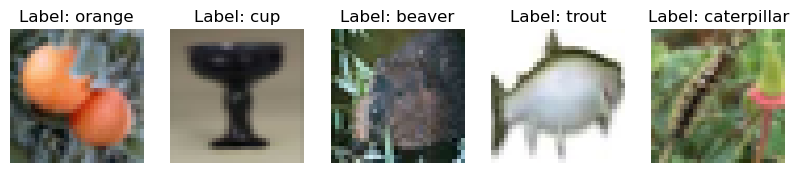

In [6]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

# Load the label names from metadata file
with open('cifar-100-python/meta', 'rb') as f:
    meta_dict = pickle.load(f, encoding='bytes')
fine_label_names = [t.decode('utf8') for t in meta_dict[b'fine_label_names']]

# Set the number of images to display
num_images = 5

# Get the indices of num_images random images
indices = random.sample(range(len(train_dataset)), num_images)

# Load the images and labels at the selected indices
images = train_dataset[indices][0]
labels = train_dataset[indices][1]

# Plot the images and their corresponding labels
fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
for i in range(num_images):
    # Convert tensor to numpy array and transpose axes
    image_array = np.transpose(images[i], (1, 2, 0))
    # Normalize pixel values to range [0, 1]
    image_array = image_array / 255.0
    axs[i].imshow(image_array)
    # Get the corresponding label name from the fine_label_names list
    label_name = fine_label_names[labels[i]]
    axs[i].set_title(f"Label: {label_name}")
    axs[i].axis('off')

plt.show()

## 2. Model: VGG16 from Scratch
- First Layer needs 3 channels for images 
- Starting with convolutional layers (64 filters)
- last layer needs 100 outputs for the classes 
        
Model structure:

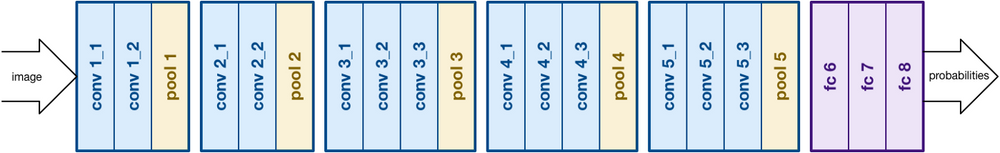


- Euqation for Conv2:

- $H_{out} = ((H_{in}+2*padding[0]dialtion[0]*(kernelSize[0]-1))/stride[0])+1$
- $W_{out} = ((W_{in}+2*padding[1]dialtion[1]*(kernelSize[1]-1))/stride[1])+1$

- Example Layer1: H_{in}=32, kernelSize=3, stride=1, padding=1, channels=64 (default delation=1), batch_size=64
  - H_{out} = W_{out} = ((32+2*1-1*(3-1)-1)/1)+1 = 32
  - Output layer1: 64x64x32x32

source: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


Transfomation from the Image:
- Shape of the input batch:  torch.Size([64, 3, 32, 32])
- After layer1:  torch.Size([64, 64, 32, 32])
- After layer2:  torch.Size([64, 64, 16, 16])
- After layer3:  torch.Size([64, 128, 16, 16])
- After layer4:  torch.Size([64, 128, 8, 8])
- After layer5:  torch.Size([64, 256, 8, 8])
- After layer6:  torch.Size([64, 256, 8, 8])
- After layer7:  torch.Size([64, 256, 4, 4])
- After layer8:  torch.Size([64, 512, 4, 4])
- After layer9:  torch.Size([64, 512, 4, 4])
- After layer10:  torch.Size([64, 512, 2, 2])
- After layer11:  torch.Size([64, 512, 2, 2])
- After layer12:  torch.Size([64, 512, 2, 2])
- After layer13:  torch.Size([64, 512, 1, 1])
- After layer14:  torch.Size([64, 512])
- After layer15:  torch.Size([64, 4096])
- After layer415:  torch.Size([64, 4096])
- Output:  torch.Size([64, 100])

source: 
- https://blog.paperspace.com/vgg-from-scratch-pytorch/
- https://www.kaggle.com/code/datastrophy/vgg16-pytorch-implementation/notebook

## 2.1 Build architecture

In [7]:
num_classes = 100

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        #print('Shape of the input batch: ', x.shape)
        out = self.layer1(x)
        #print('After layer1: ', out.shape)
        out = self.layer2(out)
        #print('After layer2: ', out.shape)
        out = self.layer3(out)
        #print('After layer3: ', out.shape)
        out = self.layer4(out)
        #print('After layer4: ', out.shape)
        out = self.layer5(out)
        #print('After layer5: ', out.shape)
        out = self.layer6(out)
        #print('After layer6: ', out.shape)
        out = self.layer7(out)
        #print('After layer7: ', out.shape)
        out = self.layer8(out)
        #print('After layer8: ', out.shape)
        out = self.layer9(out)
        #print('After layer9: ', out.shape)
        out = self.layer10(out)
        #print('After layer10: ', out.shape)
        out = self.layer11(out)
        #print('After layer11: ', out.shape)
        out = self.layer12(out)
        #print('After layer12: ', out.shape)
        out = self.layer13(out)
        #print('After layer13: ', out.shape)
        out = out.reshape(out.size(0), -1)
        #print('After layer14: ', out.shape)
        out = self.fc(out)
        #print('After layer15: ', out.shape)
        out = self.fc1(out)
        #print('After layer415: ', out.shape)
        out = self.fc2(out)
        #print('Output: ', out.shape)
        return out

In [9]:
# Create instance of the model
model = VGG16(num_classes)

### Overview model:

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number trainable parameters: ', pytorch_total_params)

#source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

Number trainable parameters:  34015396


In [11]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [12]:
# for 64 images probability of the 100 classes (first batch)
prediction_first_batch = model(first_batch[0])
print('All predictions for the first batch (64 images, probability for the 100 classes): \n', prediction_first_batch)

All predictions for the first batch (64 images, probability for the 100 classes): 
 tensor([[ 0.4148, -0.1441,  0.0776,  ..., -0.0438,  0.0462,  0.1013],
        [-0.0336, -0.2109, -0.1853,  ...,  0.2061, -0.1089,  0.1700],
        [ 0.2094, -0.0724, -0.1302,  ...,  0.3537,  0.3423,  0.0467],
        ...,
        [ 0.2056,  0.0716,  0.1260,  ...,  0.1230,  0.2359,  0.1313],
        [-0.2411,  0.1579, -0.1740,  ..., -0.1633,  0.5675,  0.3622],
        [-0.0598, -0.0064,  0.0328,  ...,  0.2295, -0.0198,  0.2980]],
       grad_fn=<AddmmBackward0>)


## 2.2 Set hyperparamter for training 

In [13]:
num_epochs = 50
learning_rate = 0.005

model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

## 2.3 Train the model

Epoch [1/50], Step [625/625], Loss: 4.1496
Accuracy of the network on the 5000 validation images: 8.49 %
Epoch [2/50], Step [625/625], Loss: 3.5465
Accuracy of the network on the 5000 validation images: 16.37 %
Epoch [3/50], Step [625/625], Loss: 3.0763
Accuracy of the network on the 5000 validation images: 22.76 %
Epoch [4/50], Step [625/625], Loss: 2.7805
Accuracy of the network on the 5000 validation images: 27.66 %
Epoch [5/50], Step [625/625], Loss: 2.5586
Accuracy of the network on the 5000 validation images: 31.11 %
Epoch [6/50], Step [625/625], Loss: 2.3735
Accuracy of the network on the 5000 validation images: 33.99 %
Epoch [7/50], Step [625/625], Loss: 2.2069
Accuracy of the network on the 5000 validation images: 36.84 %
Epoch [8/50], Step [625/625], Loss: 2.0732
Accuracy of the network on the 5000 validation images: 38.09 %
Epoch [9/50], Step [625/625], Loss: 1.9530
Accuracy of the network on the 5000 validation images: 39.62 %
Epoch [10/50], Step [625/625], Loss: 1.8421
Acc

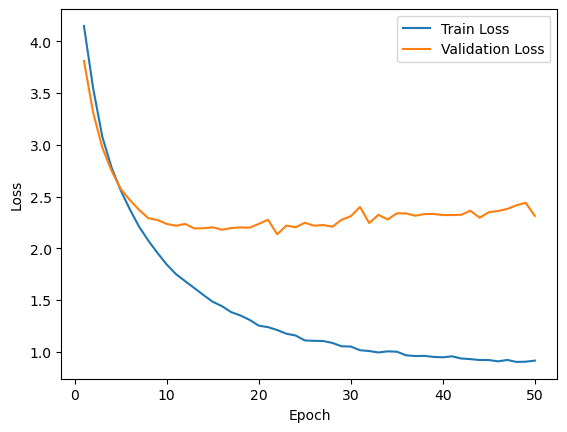

In [14]:
train_loss_list = []
val_loss_list = []
epoch_list = []

total_step = len(train_loader)

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Add up the training loss for this batch
        epoch_train_loss += loss.item()

    # Compute the average training loss for this epoch
    epoch_train_loss /= len(train_loader)

    # Append the loss to the train_loss_list
    train_loss_list.append(epoch_train_loss)
    epoch_list.append(epoch+1)
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, epoch_train_loss))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        # Append average validation loss to the val_loss_list
        val_loss /= len(valid_loader.dataset)
        val_loss_list.append(val_loss)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

# Plot the train and validation loss
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



## Save the model after paramters are trained 

In [15]:
# path to save the model
model_path = 'Trained_VGG16_Scratch.pth'

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss}, model_path)


## Load the trained paramters for the model (if needed later)

In [16]:
'''
# define model and optimizer 
model = VGG16(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# path of the model
model_path = 'trained_model_VGG16_Scratch.pth'

# load model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# No upgrading of the gradients
model.eval()
'''

"\n# define model and optimizer \nmodel = VGG16(num_classes).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\n# path of the model\nmodel_path = 'trained_model_VGG16_Scratch.pth'\n\n# load model\ncheckpoint = torch.load(model_path)\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nepoch = checkpoint['epoch']\nloss = checkpoint['loss']\n\n# No upgrading of the gradients\nmodel.eval()\n"

## Testing the model with test set and evaluate 

- TP (True Positive) is a number of right predictions that are correct when label is True and predicted as True

- TN (True Negative) is a number of right predictions that are incorrect when label is False and predicted as False

- FP (False Positive) is a number of not right predictions that are incorrect when label is False but predicted as True

- FN (False Negative) is a number of not right predictions that are correct when label is True but predicted as False

- Precision is an accuracy of positive predictions Precision represents percent of correct predictions In other words, it is ability not to label an image as positive that is actually negative Precision is calculated by following equation: Precision = TP / (TP + FP)

- Recall is a fraction of positive predictions among all True samples. In other words, it is ability to find all positive samples. Recall is calculated by following equation: Recall = TP / (TP + FN)

- F1-score is a so called weighted harmonic mean of the Precision and Recall. F1-score also known as balanced F-score or F-measure, as it incorporates Precision and Recall into computation, and, therefore, contributions of Precision and Recall to F1-score are equal. F1-score reaches its best value at 1 and worst score at 0. F1-score is calculated by following equation: F1-score = 2 (Recall Precision) / (Recall + Precision)

- Support is a number of occurrences of each class in a dataset

- Accuracy is a global accuracy of entire classifier. Accuracy is calculated by following equation: Accuracy = (TP + TN) / (TP + TN + FP + FN) (all correct / all)

- macro avg calculates the mean of the metrics, giving equal weight to each class

- weighted avg calculates the weighted mean of the metrics. It takes into account imbalance of samples' number for every class. It weights every metric by occurrences of each class in a dataset


source: 
- https://www.kaggle.com/code/valentynsichkar/confusion-matrix-for-image-classification
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [17]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # auf cpu kopieren um in numpy array umwandeln zu könenn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

target_names = fine_label_names
classification_report_result = classification_report(y_true, y_pred, target_names=target_names)
print(classification_report_result)

Accuracy of the network on the 10000 test images: 49.69 %
               precision    recall  f1-score   support

        apple       0.86      0.61      0.71       100
aquarium_fish       0.65      0.70      0.68       100
         baby       0.27      0.43      0.33       100
         bear       0.38      0.08      0.13       100
       beaver       0.20      0.35      0.25       100
          bed       0.46      0.35      0.40       100
          bee       0.43      0.52      0.47       100
       beetle       0.41      0.64      0.50       100
      bicycle       0.76      0.68      0.72       100
       bottle       0.69      0.68      0.69       100
         bowl       0.60      0.30      0.40       100
          boy       0.36      0.31      0.33       100
       bridge       0.60      0.44      0.51       100
          bus       0.60      0.41      0.49       100
    butterfly       0.46      0.29      0.36       100
        camel       0.38      0.50      0.43       100
      

In [18]:
import pandas as pd
classification_report_result_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_classification_report = pd.DataFrame(classification_report_result_dict).transpose()
df_classification_report[0:len(target_names)]

# Find best classified labels
sorted_df_precision = df_classification_report.sort_values('precision', ascending=False)
top5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Top 5 labels precision"
sorted_df_precision = top5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
motorcycle,0.871795,0.680000,0.764045,100.000000
apple,0.859155,0.610000,0.713450,100.000000
chair,0.804598,0.700000,0.748663,100.000000
road,0.771930,0.880000,0.822430,100.000000
bicycle,0.764045,0.680000,0.719577,100.000000


In [19]:
sorted_df_precision = df_classification_report.sort_values('precision')
worst5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Worst 5 labels precision"
sorted_df_precision = worst5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
otter,0.184466,0.190000,0.187192,100.000000
beaver,0.197740,0.350000,0.252708,100.000000
mouse,0.206452,0.320000,0.250980,100.000000
lizard,0.233871,0.290000,0.258929,100.000000
girl,0.262295,0.160000,0.198758,100.000000


In [20]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score', ascending=False)
top5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "Top 5 labels f1-score"
sorted_df_f1_score = top5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

,precision,recall,f1-score,support
road,0.771930,0.880000,0.822430,100.000000
motorcycle,0.871795,0.680000,0.764045,100.000000
chair,0.804598,0.700000,0.748663,100.000000
skyscraper,0.740000,0.740000,0.740000,100.000000
plain,0.666667,0.800000,0.727273,100.000000


In [21]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score')
worst5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "Worst 5 labels f1-score"
sorted_df_f1_score = worst5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

,precision,recall,f1-score,support
bear,0.380952,0.080000,0.132231,100.000000
otter,0.184466,0.190000,0.187192,100.000000
girl,0.262295,0.160000,0.198758,100.000000
shark,0.350000,0.140000,0.200000,100.000000
seal,0.301887,0.160000,0.209150,100.000000


### Create second model and check if same classes are poorly classified

In [ ]:
num_epochs = 30
learning_rate = 0.005

model2 = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [ ]:
train_loss_list = []
val_loss_list = []
epoch_list = []

total_step = len(train_loader)

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Add up the training loss for this batch
        epoch_train_loss += loss.item()

    # Compute the average training loss for this epoch
    epoch_train_loss /= len(train_loader)

    # Append the loss to the train_loss_list
    train_loss_list.append(epoch_train_loss)
    epoch_list.append(epoch+1)
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, epoch_train_loss))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        # Append average validation loss to the val_loss_list
        val_loss /= len(valid_loader.dataset)
        val_loss_list.append(val_loss)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

# Plot the train and validation loss
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
sorted_df_precision = df_classification_report.sort_values('precision')
worst5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Worst 5 labels precision"
sorted_df_precision = worst5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

In [ ]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score')
worst5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "Worst 5 labels f1-score"
sorted_df_f1_score = worst5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

## Summary:
##### - only 49 percent accurancy
##### - some classes have a very bad accurancy: seal, lobster, mouse, ...
##### - other classes are quite good: road, motorcycle, chair, ..
##### - Big generalization gap and overfitting
##### - After 20 episodes no improvement in trainigng (validation gap stays constant)
##### - Interesting: repeating training several times shows that the same classes have a high and low accurancy
##### - Some classes are more hard to learn because they have no significant features
##### - Goal: searching ways and techniques to improve 
